### A base model for LSTM (Rivanna GPU)
**Use Kernal PyTorch 1.4.0 Py3.7**  
parts are from **Neural Network Example**
(Authors: Brandon G. Jacques and Per B. Sederberg)

Here we simply drop in an LSTM module for the temporal representation. Given that it basically has a hidden layer built into it, we do not add in the extra linear layer like we did for the buffer and SITH models, however, you'll see below that it still ends up with twice as many weights to learn.

In [1]:
#! pip install --user mne

In [2]:
#!pip install --user seaborn

In [3]:
from train_util import *
from Deep_isith_EEG import *
from base_models import *
import warnings
warnings.filterwarnings('ignore')

<class 'torch.cuda.DoubleTensor'>


#### GPU is available

In [4]:
torch.cuda.is_available()

True

## Prepare data

In [5]:
# parameters
results = []
dir = "./grasp-and-lift-eeg-detection/"
kernel_size = 50000 # sliding window size to use
step = 45000 #  --the step between each slice. means overlap between batches is 1- step 
# num of epochs to train
nepochs = 12
# Just for visualizing average loss through time. 
loss_buffer_size = 100
loss_func =  torch.nn.CrossEntropyLoss()
batch_size = 2 # batch_size is a hyper parameter to tune 
train_split = 0.8
lr = 0.01


# start training, iterate thorugh events
for i in range(1,2): # There are six events 1 - 6
    nClass = i

    train_x_list = []
    train_y_list = []

    for file in os.listdir(dir):
        if file[:-4].endswith('_data'):
            raw = creat_mne_raw_object(dir+file,read_events=True)
            input_tensor,target_tensor = filter_standardization(raw,window_size = 1000,
                              l_freq = 0,h_freq = 30,nClass = nClass)
            input_tensor = input_tensor.squeeze()
            # patches data 
            patches_train = input_tensor.unfold(dimension = 1, size = kernel_size, step = step).permute(1,0,2)
            patches_label = target_tensor.unfold(0, kernel_size, step)
            #print(patches_train.shape, patches_label.shape)

            # append to a list
            train_x_list.append(patches_train)
            train_y_list.append(patches_label)  
    print("Finished ! {} data are loaded".format(len(train_x_list)))
    print("Processing event number {}".format(nClass))
    
    # concatenate them
    train_x_t = torch.cat(train_x_list, dim=0)
    train_y_t = torch.cat(train_y_list, dim=0)
    print(train_x_t.shape, train_y_t.shape)


    # create dataloader class
    train_loader,val_loader = split_train_val(train_x_t ,train_y_t,
                    batch_size = batch_size, train_split = train_split)
    
    

    #------------------ model configuration ------------------------#
    # number of output feature should be 2 since we always train one at a time, so now 1+1
    #nClass = 6
    hidden_size = 50
    # make sure this in_features matches the number of feutures in the EEG data
    model = LSTM_EEG(in_features = 32, hidden_dim = hidden_size, 
                      out_feuture = 2,num_layers =2, dropout=0).double()

    optimizer = torch.optim.Adam(model.parameters())
    # map model to GPU
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    #------------------- start training ---------------------------#
    perf = []
    perf = train_model(model, ttype, train_loader, val_loader,
                    optimizer, loss_func, epochs=nepochs)
    results.append(perf)

Finished ! 8 data are loaded
Processing event number 1
torch.Size([26, 32, 50000]) torch.Size([26, 50000])


In [19]:
import pandas as pd
for i in range(len(results)):
    perf = results[i]
    new_df = pd.DataFrame(perf)
    new_df['event'] = event[i]
    df = df.append(new_df)

df.to_csv('lstm_training_output.csv')

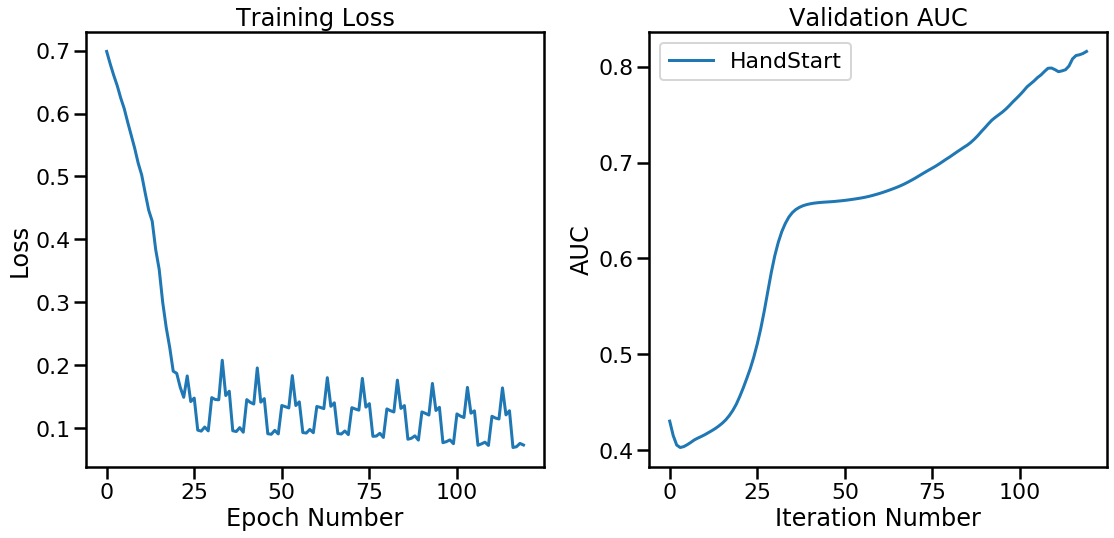

In [6]:
####    Plot training result
fig = plt.figure(figsize=(16, 8),constrained_layout=False)
event = ['HandStart','FirstDigitTouch','BothStartLoadPhase',
            'LiftOff','Replace','BothReleased']
for i in range(len(results)):
    perf = results[i]
    # build a dataframe
    loss = np.array(perf['loss'])
    acc = np.array(perf['acc'])
    iteration = np.array(perf['iteration'])
    final_result = pd.DataFrame({'iteration' : iteration,'loss' : loss, 'accuracy' : acc}) 
    final_result.head()
    
    ax = fig.add_subplot(121)
    sn.lineplot(data=final_result, x='iteration', y='loss',
                ax=ax)
    ax.set_xlabel("Iteration Number")
    ax.set_ylabel("Loss")
    ax.set_title("Training Loss")


    ax = fig.add_subplot(122)
    sn.lineplot(data=final_result, x='iteration', y='accuracy', 
                legend='brief', label=event[i], ax=ax)
    ax.set_xlabel("Iteration Number")
    ax.set_ylabel("AUC")
    ax.set_title("Validation AUC")
    plt.tight_layout()

plt.show()

## Model evaluation

In [227]:
# reshape and flatten the test_Y
y_true = np.ndarray.flatten(test_Y.detach().cpu().numpy())

In [228]:
y_true.shape

(50000,)

In [229]:
# predict using test_X
out_val =lstm_model(test_X)

# pass through a softmax to tansform to probability
res = torch.nn.functional.softmax(out_val, dim=2)
y_pred = res[:,:,1]

# flatten the predicted result 
y_score = np.ndarray.flatten(y_pred.detach().cpu().numpy())

In [230]:
y_score.shape

(50000,)

In [231]:
roc_auc_score(y_true = y_true,y_score = y_score)

0.7108676269091219